# 0. CARREGANDO AS BIBLIOTECAS

In [354]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


import warnings
warnings.filterwarnings('ignore')

# 1. CARREGANDO AS BASES DE DADOS

In [319]:
df_item_categories = pd.read_csv("data/item_categories.csv")
df_items = pd.read_csv("data/items.csv")
df_shops = pd.read_csv("data/shops.csv")
df_sales_train = pd.read_csv("data/sales_train.csv")

In [320]:
print(df_item_categories.head())
print(df_items.head())
print(df_shops.head())

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"  

In [321]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# 2. ANÁLISE DESCRITIVA DOS DADOS

In [322]:
print('='*30, 'Descrição das variaveis', '='*30)
print()
print(f'Quantidade de variaveis: {df_sales_train.shape[1]}')
print(f'Quantidade de entrada: {df_sales_train.shape[0]}')

print()
print('identificando os tipos de variaveis')
print()
df_sales_train.info()

============================== Descrição das variaveis ==============================

Quantidade de variaveis: 6
Quantidade de entrada: 2935849

identificando os tipos de variaveis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [323]:
def nulos_e_duplicados (dataframe) :
    print(f'Nulos : {dataframe.isna().sum().sum()}')
    print(f'Duplicados : {dataframe.duplicated().sum()}')

In [324]:
nulos_e_duplicados(df_sales_train)

Nulos : 0
Duplicados : 6


In [325]:
df_sales_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [326]:
# transformando a variavel date em datetime

df_sales_train['date'] = df_sales_train['date'].astype('datetime64[ns]')
df_sales_train['item_id'] = df_sales_train['item_id'].astype('object')

Como o base de dados apresenta só 6 dados dulicados, vamos dropa-lo do datset para uma melhor análise.

In [327]:
#Removendo os dados dulpicados do dataset
df_sales_train.drop_duplicates(inplace=True)
nulos_e_duplicados(df_sales_train)


Nulos : 0
Duplicados : 0


In [328]:
df_sales_train  = df_sales_train.sort_values(by= 'date', axis=0, ascending=True).reset_index(drop=True)

# 3. Visualização dos Dados

In [358]:
lista = list(df_sales_train.select_dtypes(include='number').columns)

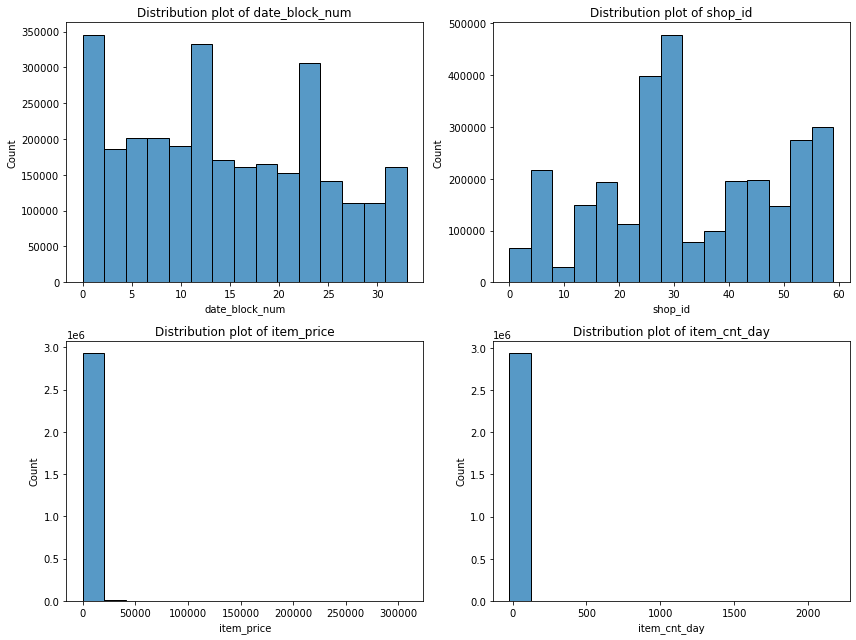

In [366]:
#plotando as variaveis numericas
plt.figure(figsize=(12,9))
for i in range(len(lista)):
  plt.subplot(2,2,i+1)
  sns.histplot(x=lista[i], bins=15,data=df_sales_train)
  plt.title('Distribution plot of {}'.format(lista[i]))
  plt.tight_layout()

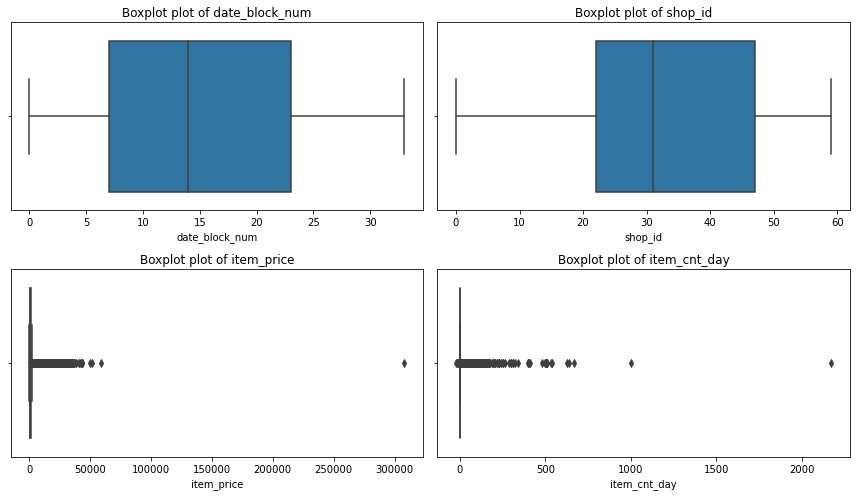

In [365]:
plt.figure(figsize=(12,7))
for i in range(len(lista)):
  plt.subplot(2,2,i+1)
  sns.boxplot(df_sales_train[lista[i]])
  plt.title('Boxplot plot of {}'.format(lista[i]))
  plt.tight_layout()

## 3.1 Visualizando os dados por Produto

In [329]:
# Definindo algumas funções de visualização dos dados

def plot_line(df,x,y, title):
  fig = px.line(df,x=x,y=y, template= 'simple_white', markers= False )
  fig.update_layout(title={'text': title, 'y': 0.98, 'x': 0.5})
  fig.update_xaxes(zeroline = True, zerolinewidth =2, title = '')
  fig.update_yaxes(showticklabels = False, title= '' , showline = False, showticksuffix= 'none', ticks = '')
  fig.show()

In [330]:
#Filtrando o produto por quantindade de vendas para melhor visualização
item_top10 = pd.DataFrame(df_sales_train.groupby('item_id')['item_cnt_day'].sum()\
                        .rename({'item_cnt_day': 'quantidade'}, axis='columns'))\
                        .sort_values(by = ['item_cnt_day'], ascending = False )\
                            .reset_index().head(10)

In [331]:
item_top10

,item_id,item_cnt_day
0,20949,187642.0
1,2808,17245.0
2,3732,16642.0
3,17717,15830.0
4,5822,14515.0
5,3734,11688.0
6,6675,10289.0
7,3731,10099.0
8,1855,10032.0
9,16787,9227.0


Na tabela acima mostra o top 10 de produtos por quantidade de vendas. Por isso, o produto escolhido para análise vai ser o 20949.

In [332]:
#Filtrando o produto 20949 na base de dados

Item_20949 = df_sales_train[df_sales_train['item_id'] == 20949].reset_index(drop= True)

In [333]:
Item_20949.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-05,4,53,20949,5.0,8.0
1,2013-01-05,4,46,20949,5.0,14.0
2,2013-01-05,4,31,20949,5.0,1.0
3,2013-01-05,4,43,20949,5.0,3.0
4,2013-01-05,4,16,20949,5.0,10.0


In [334]:
figura = pd.DataFrame(Item_20949.groupby('date_block_num')['item_cnt_day'].sum()).reset_index()
plot_line(figura,'date_block_num','item_cnt_day', 'Quantidade de vendas do Produto 20949 por mês')

In [335]:
figura = pd.DataFrame(Item_20949.groupby('date')['item_cnt_day'].sum()).reset_index()
plot_line(figura,'date','item_cnt_day', 'Quantidade de vendas do Produto 20949 por dia')

## 3.2 Visualizando os dados por loja

Agora, vamos escolher a loja que vai ser utilizada para análise de forecasting

In [336]:
loja_top10 = pd.DataFrame(Item_20949.groupby('shop_id')['item_cnt_day'].sum().rename({'item_cnt_day': 'quantidade'}, axis='columns'))\
    .sort_values(by='item_cnt_day', ascending=False)
loja_top10.head(10)

,item_cnt_day
shop_id,
31,19934.0
25,14343.0
28,13458.0
54,12323.0
42,10514.0
27,8265.0
57,6116.0
47,4530.0
22,4382.0


A Loja 31 é que apresenta mais quantidade do produto escolhido e consequentemente é o produto mais vendido. Então, é por esse motivo que vai ser a loja escolhida para a nossa análise.

## 3.2 Visualização da loja 31 pelo produto 20949

In [337]:
# Filtrando a loja da 31 no dataset
df_shop31_Item_20949= Item_20949[Item_20949['shop_id'] == 31].reset_index(drop = True)

In [338]:
df_shop31_Item_20949.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-05,4,31,20949,5.0,1.0
1,2013-01-06,5,31,20949,5.0,29.0
2,2013-01-07,6,31,20949,5.0,29.0
3,2013-01-08,7,31,20949,5.0,22.0
4,2013-01-09,8,31,20949,5.0,41.0


In [339]:
fig = px.histogram(df_shop31_Item_20949, x='item_cnt_day', template= 'simple_white')
fig.update_layout(title={'text': 'Distribuição da variavel "item_cnt_day"', 'y': 0.98, 'x': 0.5})
fig.update_xaxes(title = 'Quantidade_produto')
fig.update_yaxes(title= 'Frequência')
fig.show()

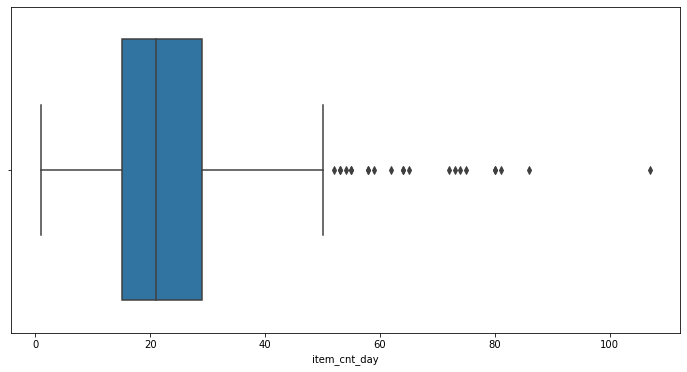

In [340]:
plt.figure(figsize=(12,6))
sns.boxplot(df_shop31_Item_20949['item_cnt_day'])

Como podemos observar no histograma que apreesenta um distribuição assimétrica a direita, com alguns outliers de qunatidades de vendas a partir de 60 em concordância com o gráfico de box-plot abaixo que nos mostra que 50% da qunatidade dos produtos está um pouco acima de 20.

In [341]:
plot_line(df_shop31_Item_20949,'date','item_cnt_day', 'Quantidade de vendas do Produto 20949 por dia')

In [342]:
df_mensal = df_shop31_Item_20949.copy() #fazendo uma cópia do dataset
df_mensal.set_index('date', inplace = True) #transformando a coluna data em index
df_mensal = df_mensal.resample(rule = 'M').last() #reordenando o dataset por mês

In [343]:
plot_line(df_mensal,df_mensal.index,'item_cnt_day', 'Quantidade de vendas do Produto 20949 por mês')

Como podemos observar o produto estudado aqui,tem um saida maior no começo dos anos. Apresenta picos em janeiro de 2014 e em janeiro de 2015.

In [344]:
df_mensal['sales_month'] = df_mensal['item_price'] * df_mensal['item_cnt_day']
plot_line(df_mensal,df_mensal.index,'sales_month', ' Vendas do Produto 20949 por mês')

### 3.2.1 Análise de Correlação

Text(0.5, 1.0, 'Correlação da quantidade do produto pelo tempo ')

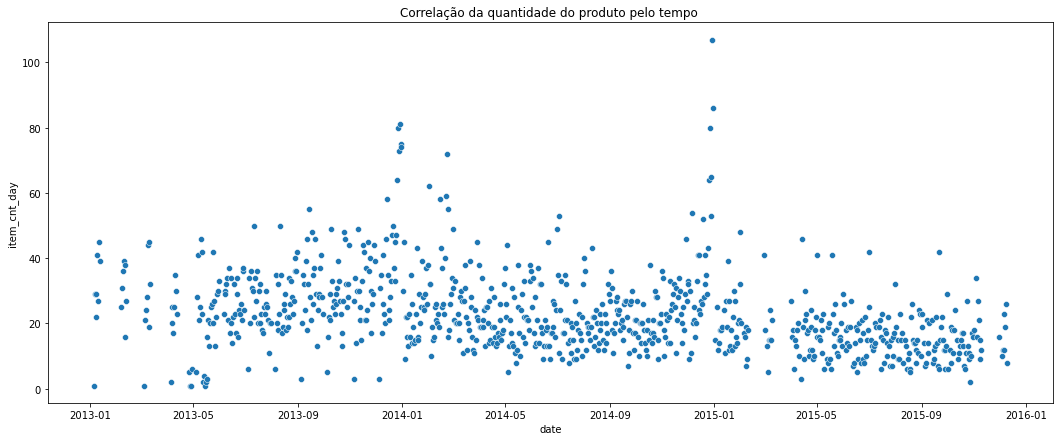

In [345]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='date',y='item_cnt_day',data=df_shop31_Item_20949)
plt.title('Correlação da quantidade do produto pelo tempo ')

### 3.2.2 Decomposição dos dados

In [346]:
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

In [347]:
df_shop31_Item_20949.set_index('date', inplace = True) #transformando a coluna data em index

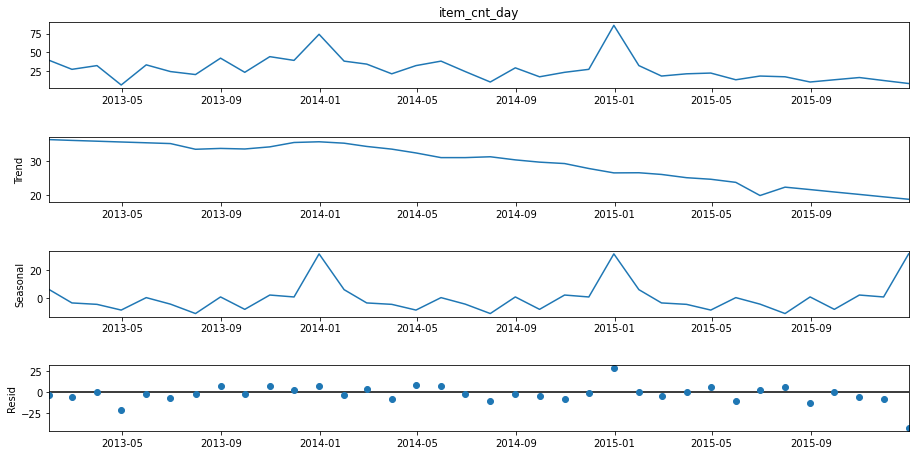

In [350]:
seasonal_decompose (df_mensal['item_cnt_day'])

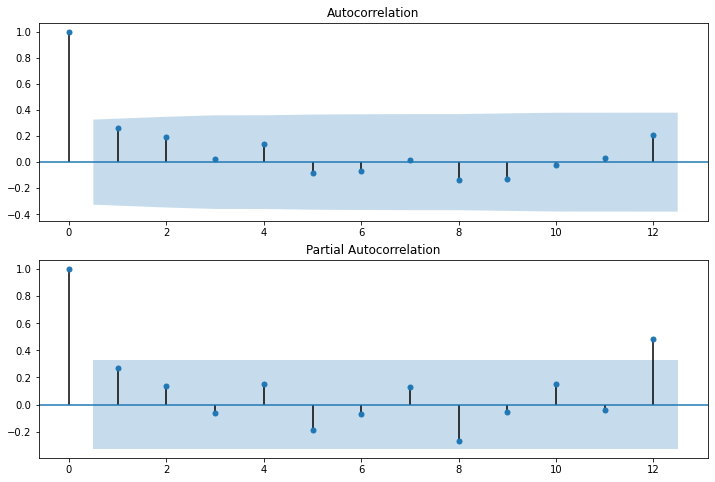

In [351]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_mensal['item_cnt_day'].values.squeeze(), lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_mensal['item_cnt_day'], lags=12, ax=ax2)

### 3.2.3 Checando a Estacionariedad dos Dados

In [352]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=3).mean() 
    rolstd = pd.Series(timeseries).rolling(window=3).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

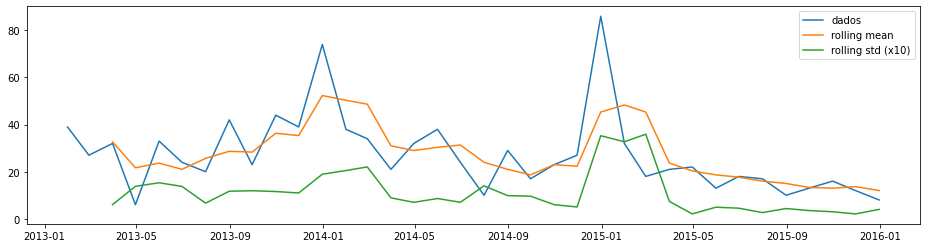

In [353]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(df_mensal['item_cnt_day'], 'dados')

In [355]:
def ADF_test(timeseries, dataDesc):
    print(f' > A série {dataDesc} é estacionária ?')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print(f'Test statistic = {dftest[0]:.3f}')
    print(f'P-value = {dftest[1]:.3f}')
    print('Critical values :')
    for k, v in dftest[4].items():
        print(f'\t{k}: {v} - A base é {"não" if v < dftest[0] else ""} estacionária com {100-int(k[:-1])}% confiança')

In [357]:
ADF_test(df_shop31_Item_20949['item_cnt_day'],'attrition')

 > A série attrition é estacionária ?
Test statistic = -4.708
P-value = 0.000
Critical values :
	1%: -3.438066656679015 - A base é  estacionária com 99% confiança
	5%: -2.8649462783472424 - A base é  estacionária com 95% confiança
	10%: -2.5685837702422147 - A base é  estacionária com 90% confiança
